In [ ]:
# !pip install --quiet --pre dgl-cu101
# !pip install --quiet torch==1.6.0

In [1]:
import argparse
import itertools
import os
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
import pandas as pd
import scipy.sparse as sp
import time
from tqdm import tqdm, tqdm_notebook,tnrange
tqdm.pandas(position=0, leave=True)
import math 

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import dgl.function as fn
from dgl.ops import edge_softmax

from functools import partial
import seaborn as sns
import pickle
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
import tsne_func
print("torch version is {}".format(th.__version__))
print("DGL version is {}".format(dgl.__version__))

Using backend: pytorch


torch version is 1.6.0
DGL version is 0.6a210131


In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [3]:
data_dir="/workspace/cjiang/eagle_project/CAP_graph/CAP_Update/"

start=time.time()
with open(os.path.join(data_dir,"CAP_Graph"),"rb") as f:
    G,multi_label,binary_label,\
    train_mask_multi_label,  val_mask_multi_label,  test_mask_multi_label,\
    train_mask_binary_label, val_mask_binary_label, test_mask_binary_label=pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))

It took 10.5301 seconds to load graph


In [4]:
utils.graph_show(G)

**************************************************
Node_types:  ['usaanr']
Edge_types:  ['AUTO_RELATED', 'Brother_Sister', 'Busi_rel_Other', 'Child', 'Ex-Spouse', 'Parent', 'Pers_rel_Other', 'SPONSEE', 'SPONSOR', 'Spouse', 'Step-Child', 'Step-Parent']
**************************************************
Canonical Etypes of Graph is:

usaanr              AUTO_RELATED        usaanr              
usaanr              Brother_Sister      usaanr              
usaanr              Busi_rel_Other      usaanr              
usaanr              Child               usaanr              
usaanr              Ex-Spouse           usaanr              
usaanr              Parent              usaanr              
usaanr              Pers_rel_Other      usaanr              
usaanr              SPONSEE             usaanr              
usaanr              SPONSOR             usaanr              
usaanr              Spouse              usaanr              
usaanr              Step-Child          usaanr          

In [5]:
usaanr_feat=[]
for key, scheme in G.node_attr_schemes(ntype="usaanr").items():
    usaanr_feat.append(key)
usaanr_feat=[x for x in usaanr_feat if x not in ['ZIPCD']]

print()
print("The features associated with USAA Member are\n ")
for i in usaanr_feat:
    print(i)


The features associated with USAA Member are
 
usaayr
AGE_BAND
ORIGEL
ELIG2
cmpyelig
SEX
MARST
BRANCH
ENLPAYGD
MILST
MLIST_OrigStat
ACTCORP
STATE
Segment


In [6]:
## USAA Members Features Embedding
class USAANR_Embedding(nn.Module):
    def __init__(self,G,feature_size):
        super(USAANR_Embedding,self).__init__()
        self.G=G.to(device)
        self.feature_size=feature_size
        ## Embedding matrices for features of nodes.
        self.emb = nn.ModuleDict()
        
        for i,col in enumerate(usaanr_feat):
            self.emb[col]=nn.Embedding(G.nodes['usaanr'].data[col].max().item()+1, feature_size)
    
    def forward(self,nid):
        nid=nid.to(device)
        extra_repr=[]
        for i,col in enumerate(usaanr_feat):
            ndata=self.G.nodes['usaanr'].data[col]
            extra_repr.append(self.emb[col](ndata[nid]).squeeze(1))
        return th.stack(extra_repr, 0).sum(0)


class HGTLayer(nn.Module):
    def __init__(self,
                 in_dim,
                 out_dim,
                 node_dict,
                 edge_dict,
                 n_heads,
                 dropout = 0.2,
                 use_norm = False):
        super(HGTLayer, self).__init__()

        self.in_dim        = in_dim
        self.out_dim       = out_dim
        self.node_dict     = node_dict
        self.edge_dict     = edge_dict
        self.num_types     = len(node_dict)
        self.num_relations = len(edge_dict)
        self.total_rel     = self.num_types * self.num_relations * self.num_types
        self.n_heads       = n_heads
        self.d_k           = out_dim // n_heads
        self.sqrt_dk       = math.sqrt(self.d_k)
        self.att           = None

        self.k_linears   = nn.ModuleList()
        self.q_linears   = nn.ModuleList()
        self.v_linears   = nn.ModuleList()
        self.a_linears   = nn.ModuleList()
        self.norms       = nn.ModuleList()
        self.use_norm    = use_norm

        for t in range(self.num_types):
            self.k_linears.append(nn.Linear(in_dim,   out_dim))
            self.q_linears.append(nn.Linear(in_dim,   out_dim))
            self.v_linears.append(nn.Linear(in_dim,   out_dim))
            self.a_linears.append(nn.Linear(out_dim,  out_dim))
            if use_norm:
                self.norms.append(nn.LayerNorm(out_dim))

        self.relation_pri   = nn.Parameter(th.ones(self.num_relations, self.n_heads))
        self.relation_att   = nn.Parameter(th.Tensor(self.num_relations, n_heads, self.d_k, self.d_k))
        self.relation_msg   = nn.Parameter(th.Tensor(self.num_relations, n_heads, self.d_k, self.d_k))
        self.skip           = nn.Parameter(th.ones(self.num_types))
        self.drop           = nn.Dropout(dropout)

        nn.init.xavier_uniform_(self.relation_att)
        nn.init.xavier_uniform_(self.relation_msg)

    def forward(self, sg, h):
        with sg.local_scope():
            node_dict, edge_dict = self.node_dict, self.edge_dict
            
            #### remove the edges where the number of edges==0
#             etypes_with_nonzero_edges = [etype for etype in sg.etypes if sg.num_edges(etype) > 0]
#             sg=sg.edge_type_subgraph(etypes_with_nonzero_edges)
            
            for srctype, etype, dsttype in sg.canonical_etypes:
                sub_graph = sg[srctype, etype, dsttype]

                if sub_graph.num_edges()==0:
                    sub_graph.edata['t'] = th.zeros([sub_graph.num_edges(),self.n_heads,1]).to(device)
                else:
                    k_linear = self.k_linears[node_dict[srctype]]
                    v_linear = self.v_linears[node_dict[srctype]]
                    q_linear = self.q_linears[node_dict[dsttype]]

                    k = k_linear(h[srctype]).view(-1, self.n_heads, self.d_k)
                    v = v_linear(h[srctype]).view(-1, self.n_heads, self.d_k)
                    q = q_linear(h[dsttype][0:sg.num_dst_nodes()]).view(-1, self.n_heads, self.d_k)

                    e_id = self.edge_dict[etype]

                    relation_att = self.relation_att[e_id]
                    relation_pri = self.relation_pri[e_id]
                    relation_msg = self.relation_msg[e_id]

                    k = th.einsum("bij,ijk->bik", k, relation_att)
                    v = th.einsum("bij,ijk->bik", v, relation_msg)

                    sub_graph.srcdata['k'] = k
                    sub_graph.dstdata['q'] = q
                    sub_graph.srcdata['v'] = v

                    sub_graph.apply_edges(fn.v_dot_u('q', 'k', 't'))
                    attn_score = sub_graph.edata.pop('t').sum(-1) * relation_pri / self.sqrt_dk
                    attn_score = edge_softmax(sub_graph, attn_score, norm_by='dst')

                    sub_graph.edata['t'] = attn_score.unsqueeze(-1)
                    
#                     if 't' not in list(sub_graph.edata.keys()): 
#                         sub_graph.edata['t'] = th.zeros([sub_graph.num_edges(),self.n_heads,1])

#             for etype in sg.etypes:
#                 if 't' not in list(sg.edges[etype].data.keys()): 
#                     sg.edges[etype].data['t'] = th.zeros([sg.num_edges(etype),self.n_heads,1])
        
            sg.multi_update_all({etype : (fn.u_mul_e('v', 't', 'm'), fn.sum('m', 't')) \
                                for etype in edge_dict}, cross_reducer = 'mean')

            new_h = {}
            for ntype in sg.ntypes:
                '''
                    Step 3: Target-specific Aggregation
                    x = norm( W[node_type] * gelu( Agg(x) ) + x )
                '''
                n_id = node_dict[ntype]
                alpha = th.sigmoid(self.skip[n_id])
                t = sg.dstnodes[ntype].data['t'].view(-1, self.out_dim)
                trans_out = self.drop(self.a_linears[n_id](t))
                trans_out = trans_out * alpha + h[ntype][0:sg.num_dst_nodes()] * (1-alpha)
                if self.use_norm:
                    new_h[ntype] = self.norms[n_id](trans_out)
                else:
                    new_h[ntype] = trans_out
            return new_h

class HGT(nn.Module):
    def __init__(self, G, node_dict, edge_dict, in_feat, h_dim, out_feat, n_layers, n_heads, use_norm = True):
        super(HGT, self).__init__()
        self.G=G
        self.node_dict = node_dict
        self.edge_dict = edge_dict
        self.gcs = nn.ModuleList()
        self.in_feat = in_feat
        self.h_dim = h_dim
        self.out_feat = out_feat
        self.n_layers = n_layers
        self.adapt_ws  = nn.ModuleList()
        for t in range(len(node_dict)):
            self.adapt_ws.append(nn.Linear(in_feat,   h_dim))
        for _ in range(n_layers):
            self.gcs.append(HGTLayer(h_dim, h_dim, node_dict, edge_dict, n_heads, use_norm = use_norm))
        self.out = nn.Linear(h_dim, out_feat)
        
        self.node_embed=nn.ModuleDict()
        self.node_embed['usaanr'] = USAANR_Embedding(self.G,self.in_feat)
           
    def forward(self, input_nodes, blocks=None):
        H = {}
        for ntype, nid in input_nodes.items():
            nid = input_nodes[ntype]
            H[ntype] = F.gelu(self.adapt_ws[self.node_dict[ntype]](self.node_embed[ntype](nid)))
        
        if blocks is None:
            for layer in self.gcs:
                H = layer(self.G, H)
        else:
            for layer, block in zip(self.gcs, blocks):
                H = layer(block, H)
        return self.out(H["usaanr"]), H["usaanr"]
        

In [7]:
def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=round(DF2.actual_label.sum()/(DF.actual_label.sum()*p),2)
    return gain

In [8]:
def evaluate(model, loader, labels, category, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_precision=0
    total_recall=0
    total_fscore=0
    total_auc=0
    total_pr_auc=0
    
    total_gain={}
    for p in [0.01,0.05,0.10]:
        total_gain[str(int(p*100))+"%"]=0
        
    count = 0
    count_loss=0
    
    for input_nodes_raw, seeds_raw, blocks in tqdm(loader, position=0, leave=True):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)

        input_nodes={}
        input_nodes[category]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}

        lbl = labels[seeds].to(device)
        logits,h = model(input_nodes,blocks)
        loss = F.cross_entropy(logits, lbl.squeeze(1).to(device))
        loss = F.cross_entropy(logits, lbl.squeeze(1),weight=th.Tensor([1,args.weight]).to(device))

        acc = th.sum(logits.argmax(dim=1) == lbl.squeeze(1)).item() / logits.shape[0]
        precision, recall, fscore, support = score(lbl.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy())

      
        auc = roc_auc_score(lbl.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        prec,rec,_ = precision_recall_curve(lbl.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        pr_auc=auc_score(rec,prec)
        
        total_loss += loss.item() * len(seeds) 
        total_acc += acc
        total_precision += precision[1]
        total_recall += recall[1]
        total_fscore += fscore[1]
        total_auc += auc
        total_pr_auc += pr_auc
        count += 1
        count_loss += len(seeds)
        
        arg1=logits[:,1].detach().cpu().numpy()
        arg2=lbl.cpu().numpy()
        gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
        for k in gain.keys():
            total_gain[k] += gain[k] 
    
    GAIN={}
    for k in total_gain.keys():
        GAIN[k]=total_gain[k]/count
    
    ACCURACY=total_acc / count
    LOSS=total_loss / count_loss
    AUC=total_auc/count
    PR_AUC=total_pr_auc/count
    PRECISION=total_precision/count
    RECALL=total_recall/count
    F1_SCORE=total_fscore/count
    
    return LOSS, ACCURACY, PRECISION, RECALL, F1_SCORE, GAIN, AUC, PR_AUC


#### create subgraph for the purpose of preliminary test

In [9]:
# dict_nodes={"usaanr":th.arange(G.num_nodes('usaanr'))[0:1000],'zipcode':th.arange(G.num_nodes('zipcode'))[0:100]}
# sg=dgl.node_subgraph(G,dict_nodes)

# G=G.node_type_subgraph(['usaanr'])
# dict_edges={}
# for etype in G.etypes:
#     dict_edges[etype]=th.arange(G.num_edges(etype))[0:5000]
# G=dgl.edge_subgraph(G,dict_edges)

# G.nodes['usaanr'].data["_ID"].numpy().shape,binary_label.shape, binary_label[G.nodes['usaanr'].data["_ID"]].shape

#### settings

In [10]:
parser = argparse.ArgumentParser(description='HGT')
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--h_dim", type=int, default=128,
        help="number of hidden units")
parser.add_argument("--out_dim", type=int, default=1,
        help="output dimension")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")

parser.add_argument("--n_head", type=int, default=4,
        help="number of head")
parser.add_argument("--lr", type=float, default=1e-5,
        help="learning rate")
parser.add_argument('--clip',    type=int, default=1.0) 
parser.add_argument('--max_lr',  type=float, default=1e-3) 

parser.add_argument("--num_layers", type=int, default=1,
        help="number of propagation rounds")
parser.add_argument("-e", "--n_epochs", type=int, default=1,
        help="number of training epochs")
parser.add_argument("--model_path", type=str, default="/workspace/cjiang/eagle_project/CAP_graph/hgt_model_param.pt",
        help='path for save the model')
parser.add_argument("--l2norm", type=float, default=0,
        help="l2 norm coef")

parser.add_argument("--batch-size", type=int, default=1024,
        help="Mini-batch size. If -1, use full graph training.")
parser.add_argument("--num_mini_batch", type=int, default=8,
        help="Number of minibatch.")
parser.add_argument("--fanout", type=int, default=None,
        help="Fan-out of neighbor sampling.")

parser.add_argument("--seed",  type=int,default=101,
        help="random seed for np.random.seed, torch.manual_seed and torch.cuda.manual_seed.")

parser.add_argument("--weight",  type=float,default=1,  ## number of label=0/number of label=1
        help="weight for unbalance data")

parser.add_argument("--num_worker",  type=int,default=0,  
        help="number of worker for neighbor sampling") 

args,unknown=parser.parse_known_args()

args.num_layers=1
args.dropout=0.2
args.lr=1e-3
args.l2norm=1e-3
args.n_epochs=2
args.h_dim=64
args.n_head=4
# args.batch_size=1024
args.batch_size=10240
print(args)

Namespace(batch_size=10240, clip=1.0, dropout=0.2, fanout=None, gpu=0, h_dim=64, l2norm=0.001, lr=0.001, max_lr=0.001, model_path='/workspace/cjiang/eagle_project/CAP_graph/hgt_model_param.pt', n_epochs=2, n_head=4, num_layers=1, num_mini_batch=8, num_worker=0, out_dim=1, seed=101, weight=1)


In [11]:
num_rels=len(G.etypes)
# LABEL=th.tensor(binary_label[G.nodes['usaanr'].data["_ID"]]).long()
LABEL=th.tensor(binary_label).long()
labels, count=th.unique(LABEL,return_counts=True)
num_classes=labels.shape[0]
pd.DataFrame({"label_class":labels, "count":count}).style.format({'count':'{:,}'})

,label_class,count
0,0,"19,358,913"
1,1,"6,309,591"


In [12]:
# train_mask=train_mask_binary_label[G.nodes['usaanr'].data["_ID"]] 
# val_mask=val_mask_binary_label[G.nodes['usaanr'].data["_ID"]]
# test_mask=test_mask_binary_label[G.nodes['usaanr'].data["_ID"]]

train_mask=train_mask_binary_label  
val_mask=val_mask_binary_label
test_mask=test_mask_binary_label

train_idx=th.nonzero(train_mask.squeeze()).numpy()
val_idx=th.nonzero(val_mask.squeeze()).numpy()
test_idx=th.nonzero(test_mask.squeeze()).numpy()

train_idx=th.from_numpy(train_idx).squeeze(1)    
val_idx=th.from_numpy(val_idx).squeeze(1)    
test_idx=th.from_numpy(test_idx).squeeze(1)

train_label=LABEL[train_idx]
val_label=LABEL[val_idx]
test_label=LABEL[test_idx]

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    20,534,804
validation set  2,566,850 
test set        2,566,850 


In [13]:
assert train_idx.shape[0]+val_idx.shape[0]+test_idx.shape[0] == G.num_nodes('usaanr')

In [14]:
##### check cuda
device="cpu"
use_cuda=args.gpu>=0 and th.cuda.is_available()
if use_cuda:
    th.cuda.set_device(args.gpu)
    device='cuda:%d' % args.gpu
print(device)

cuda:0


In [15]:
node_dict = {}
edge_dict = {}
for ntype in G.ntypes:
    node_dict[ntype] = len(node_dict)
for etype in G.etypes:
    edge_dict[etype] = len(edge_dict)
    G.edges[etype].data['id'] = th.ones(G.number_of_edges(etype), dtype=th.long) * edge_dict[etype] 

print(node_dict)
print(edge_dict)

{'usaanr': 0}
{'AUTO_RELATED': 0, 'Brother_Sister': 1, 'Busi_rel_Other': 2, 'Child': 3, 'Ex-Spouse': 4, 'Parent': 5, 'Pers_rel_Other': 6, 'SPONSEE': 7, 'SPONSOR': 8, 'Spouse': 9, 'Step-Child': 10, 'Step-Parent': 11}


In [16]:
for etype in G.etypes:
    for key,val in G.edges[etype].data.items():
        if key=="id":
            print("{:<15}{:<10}{:<10}".format(etype,key,th.unique(val).item()))

AUTO_RELATED   id        0         
Brother_Sister id        1         
Busi_rel_Other id        2         
Child          id        3         
Ex-Spouse      id        4         
Parent         id        5         
Pers_rel_Other id        6         
SPONSEE        id        7         
SPONSOR        id        8         
Spouse         id        9         
Step-Child     id        10        
Step-Parent    id        11        


In [17]:
model = HGT(G,
            node_dict, 
            edge_dict,
            in_feat=args.h_dim,
            h_dim=args.h_dim,
            out_feat=num_classes,
            n_layers=args.num_layers,
            n_heads=args.n_head,
            use_norm = True)

if use_cuda:
    model.cuda()

model.gcs

ModuleList(
  (0): HGTLayer(
    (k_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (q_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (v_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (a_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (norms): ModuleList(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (drop): Dropout(p=0.2, inplace=False)
  )
)

In [18]:
# optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)
optimizer = th.optim.AdamW(model.parameters())
### the number of n_epochs affects the learning rate, therefore affecting model evaluation results.
scheduler = th.optim.lr_scheduler.OneCycleLR(optimizer, total_steps=args.n_epochs, max_lr = args.max_lr)

In [19]:
# train sampler
sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
train_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': train_idx}, sampler,
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_worker)
# validation sampler
# we do not use full neighbor to save computation resources
val_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
val_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': val_idx}, val_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

test_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
test_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': test_idx}, test_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

print("The number of minibatch in training set is {:,}".format(len(train_loader)))
print("The number of minibatch in validation set is {:,}".format(len(val_loader)))
print("The number of minibatch in test set is {:,}".format(len(test_loader)))

The number of minibatch in training set is 2,006
The number of minibatch in validation set is 251
The number of minibatch in test set is 251


In [20]:
print("The total # of parameter is {:,}".format(sum([p.nelement() for p in model.parameters()]) ) )

The total # of parameter is 63,603


In [21]:
param_dict={n: p.nelement() for n, p in model.named_parameters()}
for i,j in param_dict.items():
    print("{:<70}{:<15,}".format(i,j))

gcs.0.relation_pri                                                    48             
gcs.0.relation_att                                                    12,288         
gcs.0.relation_msg                                                    12,288         
gcs.0.skip                                                            1              
gcs.0.k_linears.0.weight                                              4,096          
gcs.0.k_linears.0.bias                                                64             
gcs.0.q_linears.0.weight                                              4,096          
gcs.0.q_linears.0.bias                                                64             
gcs.0.v_linears.0.weight                                              4,096          
gcs.0.v_linears.0.bias                                                64             
gcs.0.a_linears.0.weight                                              4,096          
gcs.0.a_linears.0.bias                                

In [22]:
LOSS_EPOCH=[]
ACC_EPOCH=[]
# training loop
print("start training...")
dur = []
total_loss=0
losses=[]


# th.manual_seed(args.seed)
# th.cuda.manual_seed(args.seed)
# th.cuda.manual_seed_all(args.seed)
# np.ranom.seed(args.seed)
# random.seed(args.seed)
# th.backends.cudnn.deterministic=True

for epoch in tqdm(range(0,args.n_epochs)):
    
    model.train()
    IDX=[]
    H=[]
    LABEL_train=[]
    
    #====================================#
    #            Traning                 #
    #====================================#
    print("")
    print("========= Epoch {:} /{:}".format(epoch+1,args.n_epochs))
    print("Training...")
    t0 = time.time()
    for step, (input_nodes_raw, seeds_raw, blocks) in enumerate(train_loader):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)
        
        labels_train=LABEL[seeds]       
        labels_train = labels_train.to(device)
        
        input_nodes={}
        input_nodes["usaanr"]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
        logits,h = model(input_nodes,blocks)
        optimizer.zero_grad()
        loss = F.cross_entropy(logits, labels_train.squeeze(1),weight=th.Tensor([1,args.weight]).to(device))
#         loss = F.cross_entropy(logits, labels_train.squeeze(1))
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        arg1=logits[:,1].detach().cpu().numpy()
        arg2=labels_train.cpu().numpy()
                
        train_gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
        train_acc = th.sum(logits.argmax(dim=1) == labels_train.squeeze(1)).item() / len(seeds)
        precision, recall, fscore, support = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy())
        train_auc = roc_auc_score(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        
        prec,rec,_ = precision_recall_curve(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        train_pr_auc=auc_score(rec,prec)

        IDX.extend(seeds.detach().cpu().numpy().tolist())
        H.extend(h.detach().cpu().numpy().tolist())
        LABEL_train.extend(LABEL[blocks[-1].dstnodes["usaanr"].data[dgl.NID].cpu().numpy()].tolist())
        
        if step%(len(train_loader)//10)==0 and not step==0:
            t1 = time.time()
            elapsed=utils.format_time(t1-t0)
            print("Batch {:} of {:} | Loss {:.3f} | Accuracy {:.1%} | Gain_top-1% {:.1f} | Gain_top-5% {:.1f} | Gain_top-10% {:.1f} | ROC_AUC {:.1%}  | PR_AUC: {:.1%} | Elapsed: {:}".\
                  format(step,len(train_loader),np.mean(losses[-10:]),train_acc, train_gain["1%"],train_gain["5%"],train_gain["10%"],train_auc,train_pr_auc,elapsed))    
            
#         LOSS_EPOCH.append(loss)


    #====================================#
    #            Validation-set          #
    #====================================#
    
    print()
    print("")
    print("Running Validation on training set")
    print("")
    
    loss_train, acc_train, prec_train, recall_train, fscore_train, train_gain, train_auc,train_pr_auc = evaluate(model, train_loader,  LABEL, "usaanr", device)
    
    t2=time.time()
    
    print("loss: {:.3f} |  accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-1%: {:.1f} | Gain_top-5%: {:.1f} | Gain_top-10%: {:.1f} | ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}"\
      .format(loss_train, acc_train, prec_train, recall_train, fscore_train, train_gain["1%"],train_gain["5%"], train_gain["10%"], train_auc, train_pr_auc, utils.format_time(t2-t1)))

    
    print()
    print("")
    print("Running Validation on validation set")
    print("")
    loss_val, acc_val, prec_val, recall_val, fscore_val, val_gain, val_auc,val_pr_auc = evaluate(model, val_loader,  LABEL, "usaanr", device)
    
    t3=time.time()
    
    print("loss: {:.3f} |  accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-1%: {:.1f} | Gain_top-5%: {:.1f} | Gain_top-10%: {:.1f} | ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}"\
      .format(loss_val, acc_val, prec_val, recall_val, fscore_val, val_gain["1%"],val_gain["5%"], val_gain["10%"], val_auc, val_pr_auc, utils.format_time(t3-t2)))
    
# if args.model_path is not None:
#     th.save(model.state_dict(), args.model_path)
    
#====================================#
#             Test-set               #
#====================================#
print()
print("")
print("Running Validation in Test Dataset")
print("")
model.eval()

loss_test, acc_test, prec_test, recall_test, fscore_test, test_gain, test_auc,test_pr_auc = evaluate(model, test_loader,  LABEL, "usaanr", device)

t3=time.time()
print("loss: {:.3f} |  accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-1%: {:.1f} | Gain_top-5%: {:.1f} | Gain_top-10%: {:.1f} | ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}"\
      .format(loss_test, acc_test, prec_test, recall_test, fscore_test, test_gain["1%"], test_gain["5%"], test_gain["10%"], test_auc, test_pr_auc, utils.format_time(t3-t2)))

  0%|          | 0/2 [00:00<?, ?it/s]

start training...

========= Epoch 1 /2
Training...
Batch 200 of 2006 | Loss 0.057 | Accuracy 98.1% | Gain_top-1% 3.9 | Gain_top-5% 3.9 | Gain_top-10% 3.9 | ROC_AUC 99.5%  | PR_AUC: 98.2% | Elapsed: 0:01:52
Batch 400 of 2006 | Loss 0.052 | Accuracy 98.3% | Gain_top-1% 4.1 | Gain_top-5% 4.1 | Gain_top-10% 4.1 | ROC_AUC 99.6%  | PR_AUC: 98.6% | Elapsed: 0:03:28
Batch 600 of 2006 | Loss 0.050 | Accuracy 98.2% | Gain_top-1% 4.0 | Gain_top-5% 4.0 | Gain_top-10% 4.0 | ROC_AUC 99.6%  | PR_AUC: 98.8% | Elapsed: 0:05:03
Batch 800 of 2006 | Loss 0.050 | Accuracy 98.1% | Gain_top-1% 4.1 | Gain_top-5% 4.1 | Gain_top-10% 4.1 | ROC_AUC 99.6%  | PR_AUC: 98.6% | Elapsed: 0:06:46
Batch 1000 of 2006 | Loss 0.051 | Accuracy 98.0% | Gain_top-1% 4.1 | Gain_top-5% 4.1 | Gain_top-10% 4.1 | ROC_AUC 99.6%  | PR_AUC: 98.7% | Elapsed: 0:08:18
Batch 1200 of 2006 | Loss 0.049 | Accuracy 98.1% | Gain_top-1% 4.1 | Gain_top-5% 4.1 | Gain_top-10% 4.1 | ROC_AUC 99.7%  | PR_AUC: 99.0% | Elapsed: 0:10:08
Batch 1400 of 20

  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 0/251 [00:00<?, ?it/s]

loss: 0.048 |  accuracy: 98.16% |  precision: 93.58% | recall: 99.34% | F1_score: 96.37% | Gain_top-1%: 4.1 | Gain_top-5%: 4.1 | Gain_top-10%: 4.1 | ROC_AUC: 99.7% | PR_AUC: 98.9% | Elapsed: 0:07:04


Running Validation on validation set



 50%|█████     | 1/2 [25:28<25:28, 1528.16s/it]

loss: 0.048 |  accuracy: 98.16% |  precision: 92.89% | recall: 99.30% | F1_score: 95.98% | Gain_top-1%: 5.2 | Gain_top-5%: 5.2 | Gain_top-10%: 5.1 | ROC_AUC: 99.6% | PR_AUC: 98.6% | Elapsed: 0:01:09

========= Epoch 2 /2
Training...
Batch 200 of 2006 | Loss 0.048 | Accuracy 98.2% | Gain_top-1% 4.2 | Gain_top-5% 4.2 | Gain_top-10% 4.2 | ROC_AUC 99.7%  | PR_AUC: 98.8% | Elapsed: 0:01:23
Batch 400 of 2006 | Loss 0.047 | Accuracy 98.2% | Gain_top-1% 4.0 | Gain_top-5% 4.0 | Gain_top-10% 4.0 | ROC_AUC 99.7%  | PR_AUC: 99.0% | Elapsed: 0:03:01
Batch 600 of 2006 | Loss 0.048 | Accuracy 98.1% | Gain_top-1% 4.1 | Gain_top-5% 4.1 | Gain_top-10% 4.1 | ROC_AUC 99.6%  | PR_AUC: 98.7% | Elapsed: 0:04:35
Batch 800 of 2006 | Loss 0.048 | Accuracy 98.1% | Gain_top-1% 4.1 | Gain_top-5% 4.1 | Gain_top-10% 4.1 | ROC_AUC 99.6%  | PR_AUC: 98.7% | Elapsed: 0:06:08
Batch 1000 of 2006 | Loss 0.046 | Accuracy 98.4% | Gain_top-1% 4.0 | Gain_top-5% 4.0 | Gain_top-10% 4.0 | ROC_AUC 99.7%  | PR_AUC: 99.0% | Elapsed:

  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 1/251 [00:00<00:41,  6.10it/s]

loss: 0.047 |  accuracy: 98.18% |  precision: 93.55% | recall: 99.44% | F1_score: 96.41% | Gain_top-1%: 4.1 | Gain_top-5%: 4.1 | Gain_top-10%: 4.1 | ROC_AUC: 99.7% | PR_AUC: 98.9% | Elapsed: 0:07:52


Running Validation on validation set



  0%|          | 1/251 [00:00<00:44,  5.62it/s]

loss: 0.047 |  accuracy: 98.17% |  precision: 92.84% | recall: 99.45% | F1_score: 96.02% | Gain_top-1%: 5.2 | Gain_top-5%: 5.2 | Gain_top-10%: 5.1 | ROC_AUC: 99.7% | PR_AUC: 98.7% | Elapsed: 0:00:42


Running Validation in Test Dataset



100%|██████████| 251/251 [01:10<00:00,  3.54it/s]

loss: 0.048 |  accuracy: 98.17% |  precision: 92.83% | recall: 99.45% | F1_score: 96.02% | Gain_top-1%: 5.2 | Gain_top-5%: 5.2 | Gain_top-10%: 5.1 | ROC_AUC: 99.7% | PR_AUC: 98.7% | Elapsed: 0:01:53


#### sparsity rate of embedding vector

In [23]:
H=np.array(H)
non_zero=np.count_nonzero(H)
total_val=np.product(H.shape)
sparsity=(total_val-non_zero)/total_val
density=non_zero/total_val
print("sparsity rate is {:.2%}".format(sparsity))
print("density rate is {:.2%}".format(density))
print("embedding vector shape is {}".format(H.shape))

sparsity rate is 0.00%
density rate is 100.00%
embedding vector shape is (20534804, 64)


In [24]:
IDX_train=np.array(IDX)
H_train=np.array(H)
LABEL_train=np.array(LABEL_train)
mask_train=np.array(['train']*len(IDX_train))

In [25]:
IDX_val=[]
H_val=[]
LABEL_val=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(val_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]

    seeds=seeds_raw.to(device)
    
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_val.extend(seeds.detach().cpu().numpy().tolist())
    H_val.extend(h.detach().cpu().numpy().tolist())
    
    LABEL_val.extend(LABEL[blocks[-1].dstnodes["usaanr"].data[dgl.NID].cpu().numpy()].tolist())
    
IDX_val=np.array(IDX_val)
H_val=np.array(H_val)
LABEL_val=np.array(LABEL_val)
mask_val=np.array(['val']*len(IDX_val))

100%|██████████| 251/251 [00:56<00:00,  4.48it/s]


In [26]:
IDX_test=[]
H_test=[]
LABEL_test=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(test_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]
    
    seeds=seeds_raw.to(device)
    
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
    
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_test.extend(seeds.detach().cpu().numpy().tolist())
    H_test.extend(h.detach().cpu().numpy().tolist())
    
    LABEL_test.extend(LABEL[blocks[-1].dstnodes["usaanr"].data[dgl.NID].cpu().numpy()].tolist())
    
IDX_test=np.array(IDX_test)
H_test=np.array(H_test)
LABEL_test=np.array(LABEL_test)
mask_test=np.array(['test']*len(IDX_test))

100%|██████████| 251/251 [01:00<00:00,  4.16it/s]


In [27]:
IDX=np.concatenate((IDX_train,IDX_val, IDX_test))
H=np.concatenate((H_train,H_val, H_test))
LABEL_ALL=np.concatenate((LABEL_train,LABEL_val, LABEL_test))
mask=np.concatenate((mask_train,mask_val, mask_test))

_idx=IDX.argsort()  #### sort the node id from 0 to max_num, so that it can be matched with LABEL
embedding_vector=H[_idx]
LABEL_ALL=LABEL_ALL[_idx]
mask=mask[_idx]

print("{:<30}{}".format("shape of embedding vector",embedding_vector.shape))

shape of embedding vector     (25668504, 64)


#### visualization of embedding vectors for different categories of USAA Members

In [28]:
# LABEL_ALL.squeeze().tolist()

In [29]:
DF=pd.DataFrame({"IDX":_idx.tolist(), "MASK":mask.tolist(), "Product":LABEL_ALL.squeeze().tolist()})
prod_map={0:"Auto=False",1:"Auto=True"}
DF['Product'] = list(map(prod_map.get, DF['Product']))
DF["IDX"]=np.arange(DF.shape[0])

N=2500

train_df=DF[DF["MASK"]=="train"]
sample_df_train=train_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_train=sample_df_train["IDX"].values
prod_sample_train=DF["Product"].values[sample_id_train]
embedding_sample_train=embedding_vector[sample_id_train]

val_df=DF[DF["MASK"]=="val"]
sample_df_val=val_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_val=sample_df_val["IDX"].values
prod_sample_val=DF["Product"].values[sample_id_val]
embedding_sample_val=embedding_vector[sample_id_val]

test_df=DF[DF["MASK"]=="test"]
sample_df_test=test_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_test=sample_df_test["IDX"].values
prod_sample_test=DF["Product"].values[sample_id_test]
embedding_sample_test=embedding_vector[sample_id_test]

In [30]:
%%time
print("t-SNE dimension reduction for training embedding vector:")
print()
train_embedding = tsne_func.fit(embedding_sample_train)

t-SNE dimension reduction for training embedding vector:

[t-SNE] Iteration 100: error = 1.9098808, gradient norm = 0.0006016
[t-SNE] Iteration 200: error = 1.6350692, gradient norm = 0.0002396
[t-SNE] Iteration 300: error = 1.5273602, gradient norm = 0.0001774
[t-SNE] Iteration 400: error = 1.4722001, gradient norm = 0.0001095
[t-SNE] Iteration 500: error = 1.4362153, gradient norm = 0.0000944
[t-SNE] Iteration 600: error = 1.4080515, gradient norm = 0.0000770
[t-SNE] Iteration 700: error = 1.3834598, gradient norm = 0.0000698
[t-SNE] Iteration 800: error = 1.3616673, gradient norm = 0.0000688
[t-SNE] Iteration 900: error = 1.3464580, gradient norm = 0.0000551
[t-SNE] Iteration 1000: error = 1.3356594, gradient norm = 0.0000443
CPU times: user 3h 24min 40s, sys: 1h 5min 2s, total: 4h 29min 42s
Wall time: 46min 3s


In [31]:
a,b=np.unique(prod_sample_train,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto=False,"2,500"
1,Auto=True,"2,500"


Text(0.5, 1.0, 'Embedding Vectors t-SNE(sample=2500) \n Training Set ')

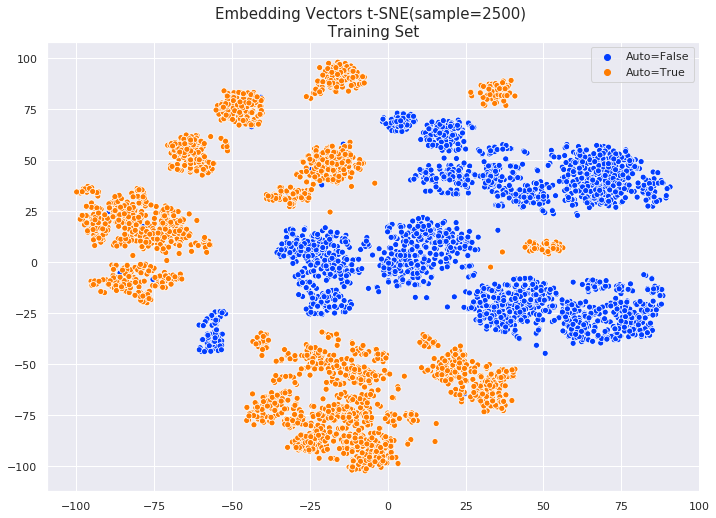

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
ax=sns.scatterplot(train_embedding[:,0], train_embedding[:,1], hue=prod_sample_train.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE(sample=2500) \n Training Set ",fontsize=15)

In [33]:
%%time
print("t-SNE dimension reduction for validation embedding:")
print()
val_embedding = tsne_func.fit(embedding_sample_val)

t-SNE dimension reduction for validation embedding:

[t-SNE] Iteration 100: error = 1.7681129, gradient norm = 0.0006786
[t-SNE] Iteration 200: error = 1.4381219, gradient norm = 0.0003388
[t-SNE] Iteration 300: error = 1.3120068, gradient norm = 0.0001622
[t-SNE] Iteration 400: error = 1.2497995, gradient norm = 0.0001116
[t-SNE] Iteration 500: error = 1.2098388, gradient norm = 0.0000911
[t-SNE] Iteration 600: error = 1.1831031, gradient norm = 0.0000753
[t-SNE] Iteration 700: error = 1.1624387, gradient norm = 0.0000598
[t-SNE] Iteration 800: error = 1.1461187, gradient norm = 0.0000531
[t-SNE] Iteration 900: error = 1.1327443, gradient norm = 0.0000444
[t-SNE] Iteration 1000: error = 1.1226753, gradient norm = 0.0000390
CPU times: user 3h 25min 48s, sys: 1h 5min 20s, total: 4h 31min 9s
Wall time: 46min 17s


In [34]:
a,b=np.unique(prod_sample_val,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto=False,"2,500"
1,Auto=True,"2,500"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=2500) \n Validation Set ')

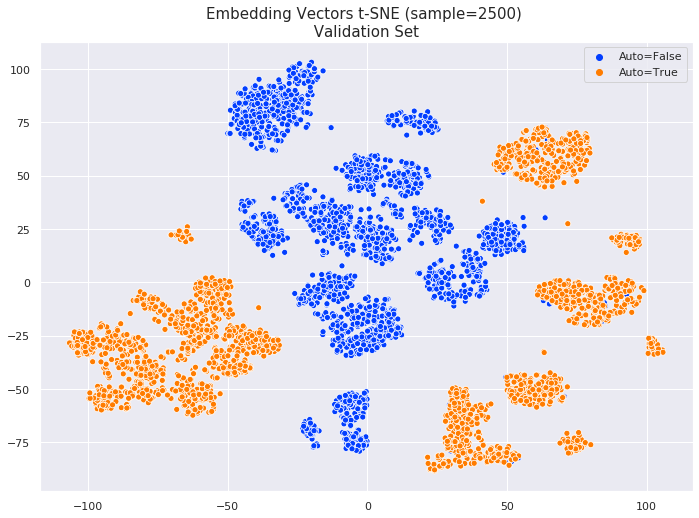

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
ax=sns.scatterplot(val_embedding[:,0], val_embedding[:,1], hue=prod_sample_val.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=2500) \n Validation Set ",fontsize=15)

In [36]:
%%time
print("t-SNE dimension reduction for test embedding:")
print()
test_embedding = tsne_func.fit(embedding_sample_test)

t-SNE dimension reduction for test embedding:

[t-SNE] Iteration 100: error = 1.7497244, gradient norm = 0.0007192
[t-SNE] Iteration 200: error = 1.4528003, gradient norm = 0.0002304
[t-SNE] Iteration 300: error = 1.3431684, gradient norm = 0.0001437
[t-SNE] Iteration 400: error = 1.2794246, gradient norm = 0.0001322
[t-SNE] Iteration 500: error = 1.2354401, gradient norm = 0.0000987
[t-SNE] Iteration 600: error = 1.2025283, gradient norm = 0.0000822
[t-SNE] Iteration 700: error = 1.1798408, gradient norm = 0.0000689
[t-SNE] Iteration 800: error = 1.1644446, gradient norm = 0.0000520
[t-SNE] Iteration 900: error = 1.1527439, gradient norm = 0.0000436
[t-SNE] Iteration 1000: error = 1.1427451, gradient norm = 0.0000384
CPU times: user 3h 25min 27s, sys: 1h 6min 15s, total: 4h 31min 42s
Wall time: 47min 35s


In [37]:
a,b=np.unique(prod_sample_test,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto=False,"2,500"
1,Auto=True,"2,500"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=2500) \n Test Set ')

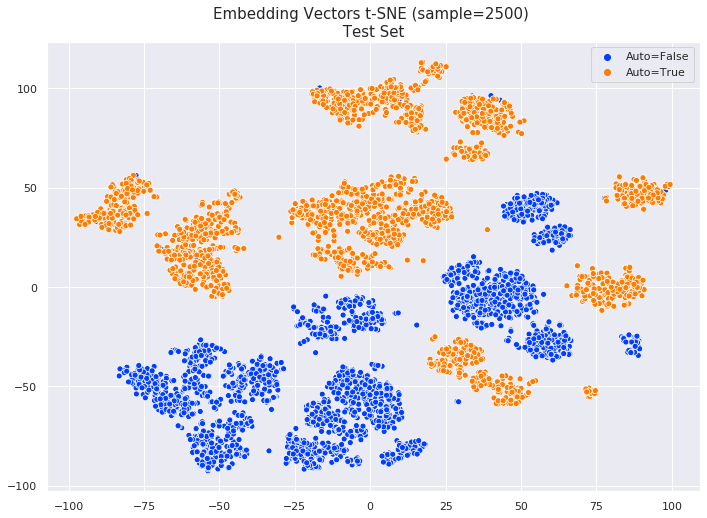

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
ax=sns.scatterplot(test_embedding[:,0], test_embedding[:,1], hue=prod_sample_test.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=2500) \n Test Set ",fontsize=15)

#### score the customers in different STATE
potential customers are defined as the customers who have the following conditions:
* currently no Auto policy
* predicted scores are greater than the 90% quantile of the predicted score of existing customers who had owned Auto policy

In [45]:
### score all the data
IDX=np.concatenate((IDX_train,IDX_val, IDX_test))
H=np.concatenate((H_train,H_val, H_test))
LABEL_ALL=np.concatenate((LABEL_train,LABEL_val, LABEL_test))
Score=nn.Linear(H.shape[1], num_classes)(th.from_numpy(H).float()).detach().numpy()
score_df=pd.DataFrame({"usaanr":IDX.tolist(),"logit":Score[:,1].tolist(),"label":LABEL_ALL.squeeze().tolist()})
score_df.sort_values(by=['usaanr'],inplace=True)
score_df.head(2)

,usaanr,logit,label
16882737,0,0.113280,1
17106455,1,0.145942,0


In [77]:
pd.DataFrame({"logit_0":Score[:,0],"logit_1":Score[:,1]}).head()

,logit_0,logit_1
0,-0.006764,-0.044049
1,0.257511,-0.264322
2,0.019717,-0.293966
3,-0.042126,-0.478800
4,0.094182,-0.417700


In [47]:
state_data=pd.read_pickle(os.path.join(data_dir,'State_Data_pickle'))
state_data.drop_duplicates(inplace=True)

In [48]:
state_list={}
state_list['32)NO CAROLINA']="NC"
state_list['46)WASHINGTON']="WA"
state_list['10)GEORGIA']="GA"
state_list['09)FLORIDA']="FL"
state_list['48)WISCONSIN']="WI"
state_list['04)CALIFORNIA']="CA"
state_list['42)TEXAS']="TX"
state_list['19)MARYLAND']="MD"
state_list['39)SO CAROLINA']="SC"
state_list['17)LOUISIANA']="LA"
state_list['47)WEST VIRGINIA']="WV"
state_list['31)NEW YORK']="NY"
state_list['41)TENNESSEE']="TN"
state_list['03)ARKANSAS']="AR"
state_list['02)ARIZONA']="AZ"
state_list['36)OREGON']="OR"
state_list['43)UTAH']="UT"
state_list['23)MISSISSIPPI']="MS"
state_list['45)VIRGINIA']="VA"
state_list['34)OHIO']="OH"
state_list['26)NEBRASKA']="NE"
state_list['16)KENTUCKY']="KY"
state_list['07)DELAWARE']="DE"
state_list['15)KANSAS']="KS"
state_list['33)NORTH DAKOTA']="ND"
state_list['05)COLORADO']="CO"
state_list['01)ALABAMA']="AL"
state_list['21)MICHIGAN']="MI"
state_list['12)ILLINOIS']="IL"
state_list['37)PENNSYLVANIA']="PA"
state_list['14)IOWA']="IA"
state_list['27)NEVADA']="NV"
state_list['24)MISSOURI']="MO"
state_list['22)MINNESOTA']="MN"
state_list['13)INDIANA']= "IN"
state_list['30)NEW MEXICO']="NM"
state_list['25)MONTANA']= 'MT'
state_list['08)DIST/COLUMBIA']= "DC"
state_list['54)ALASKA']= "AK"
state_list['703)GUAM']='703)GUAM'
state_list['35)OKLAHOMA']= "OK"
state_list['52)HAWAII']= "HI"
state_list['40)SOUTH DAKOTA']= "SD"
state_list['49)WYOMING']="WY"
state_list['11)IDAHO']= "ID"
state_list['706)NO MARIANA ISLANDS']='706)NO MARIANA ISLANDS'
state_list['721)PALAU']='721)PALAU'
state_list['44)VERMONT']="VT"
state_list['711)AMERICAN SAMOA']='711)AMERICAN SAMOA'
state_list['702)FEDERATED STATES OF MICRONESIA']='702)FEDERATED STATES OF MICRONESIA'
state_list['312)U.S. VIRGIN ISLANDS']= '312)U.S. VIRGIN ISLANDS'
state_list['707)MARSHALL ISLANDS']='707)MARSHALL ISLANDS'
state_list['29)NEW JERSEY']= "NJ"
state_list['06)CONNECTICUT']= "CT"
state_list['263)JALISCO']='263)JALISCO'
state_list['38)RHODE ISLAND']="RI"
state_list['20)MASSACHUSETTS']="MA"
state_list['28)NEW HAMPSHIRE']="NH"
state_list['272)QUINTANA ROO']='272)QUINTANA ROO'
state_list['18)MAINE']='ME'
state_list['310)PUERTO RICO']='310)PUERTO RICO'

state_data["STATE"]=state_data["STATE"].map(state_list)
state_data.sort_values(by=['usaanr'],inplace=True)
state_data["STATE"].unique()

array(['NC', 'WA', 'GA', 'FL', 'WI', 'CA', 'TX', 'MD', 'SC', 'LA', 'WV',
       'TN', 'AR', 'AZ', 'OR', 'MS', 'OH', 'VA', 'NE', 'KY', 'NY', 'DE',
       'KS', 'ND', 'AL', 'CO', 'MI', 'UT', 'IL', 'NV', 'MO', 'MN', 'IA',
       'IN', 'NM', 'MT', 'PA', 'HI', 'AK', '703)GUAM', 'OK', 'ID', 'WY',
       'DC', 'SD', nan, '706)NO MARIANA ISLANDS', '711)AMERICAN SAMOA',
       '702)FEDERATED STATES OF MICRONESIA', '721)PALAU', 'VT',
       '312)U.S. VIRGIN ISLANDS', '707)MARSHALL ISLANDS', 'CT', 'NJ',
       '263)JALISCO', '272)QUINTANA ROO', 'MA'], dtype=object)

In [42]:
print(score_df.shape)
print(state_data.shape)

(25668504, 3)
(25668504, 2)


In [46]:
state_data.head(2)

,usaanr,STATE
0,0,NC
1,1,WA


In [49]:
score_df=score_df.merge(state_data, on="usaanr",how="inner")
score_df.reset_index(drop=True,inplace=True)
print(score_df.shape)

(25668504, 4)


In [75]:
score_df.head(5)

,usaanr,logit,label,STATE
0,0,0.113280,1,NC
1,1,0.145942,0,WA
2,2,0.423158,1,GA
3,3,0.120017,1,WA
4,4,-0.118715,0,FL


In [58]:
def product_score(score_df, state, p):

    #### no product
    prod_v0=score_df[(score_df['label']==0) & (score_df['STATE']==state)]
    #### with product
    prod_v1=score_df[(score_df['label']==1) & (score_df['STATE']==state)]
    
    #### Determine the threshold value of score for the member who has owned product in each state
    threshold_value=np.percentile(prod_v1["logit"].values,p)
    
    output=prod_v0[prod_v0["logit"]>=threshold_value]
       
    num0=prod_v0.shape[0]
    
    num1=output.shape[0]
    
    Ratio=num1/num0
    
    return output, num1, num0, Ratio

In [67]:
%%time
output_TX, num1_TX, num0_TX, Ratio_TX=product_score(score_df, state="TX", p=90)
output_AZ, num1_AZ, num0_AZ, Ratio_AZ=product_score(score_df, state="AZ", p=90)
output_GA, num1_GA, num0_GA, Ratio_GA=product_score(score_df, state="GA", p=90)
output_FL, num1_FL, num0_FL, Ratio_FL=product_score(score_df, state="FL", p=90)
output_IL, num1_IL, num0_IL, Ratio_IL=product_score(score_df, state="IL", p=90)
output_MD, num1_MD, num0_MD, Ratio_MD=product_score(score_df, state="MD", p=90)
output_CA, num1_CA, num0_CA, Ratio_CA=product_score(score_df, state="CA", p=90)
output_VA, num1_VA, num0_VA, Ratio_VA=product_score(score_df, state="VA", p=90)
output_OR, num1_OR, num0_OR, Ratio_OR=product_score(score_df, state="OR", p=90)
output_OH, num1_OH, num0_OH, Ratio_OH=product_score(score_df, state="OH", p=90)

CPU times: user 2min 11s, sys: 42.1 s, total: 2min 53s
Wall time: 1min 1s


In [68]:
output_table={}
output_table["Total Members without Auto"]=[num0_TX,num0_AZ,num0_GA,num0_FL,num0_IL,num0_MD,num0_CA,num0_VA,num0_OR,num0_OH]
output_table["Potential Members"]= [num1_TX,num1_AZ,num1_GA,num1_FL,num1_IL,num1_MD,num1_CA,num1_VA,num1_OR,num1_OH]
output_table["Ratio of Potential Members"]= [Ratio_TX,Ratio_AZ,Ratio_GA,Ratio_FL,Ratio_IL,Ratio_MD,Ratio_CA,Ratio_VA,Ratio_OR,Ratio_OH]
tempt=pd.DataFrame(output_table)
tempt.index=["Texas","Arizona","Georgia","Florida","Illinois","Maryland","California","Virginia","Oregon","Ohio"]
tempt.style.format({"Total Members without Auto":"{:,}","Potential Members":"{:,}","Ratio of Potential Members":"{:.2%}"})

,Total Members without Auto,Potential Members,Ratio of Potential Members
Texas,"2,418,028","24,533",1.01%
Arizona,"605,053","5,830",0.96%
Georgia,"1,003,330","11,234",1.12%
Florida,"1,854,457","70,882",3.82%
Illinois,"407,457","3,851",0.95%
Maryland,"508,234","4,554",0.90%
California,"1,729,906","36,316",2.10%
Virginia,"982,864","16,224",1.65%
Oregon,"296,249","2,365",0.80%
Ohio,"495,738","2,564",0.52%


In [71]:
output_df=pd.DataFrame(columns=["usaanr","STATE"])
output_df=output_df.append(output_TX.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_AZ.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_GA.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_FL.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_IL.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_MD.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_CA.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_VA.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_OR.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_OH.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df["STATE"].value_counts(dropna=False)

FL    70882
CA    36316
TX    24533
VA    16224
GA    11234
AZ     5830
MD     4554
IL     3851
OH     2564
OR     2365
Name: STATE, dtype: int64

In [73]:
output_df.to_csv("Potential_Auto.csv.bz2",sep="\t",compression="bz2",index=False)

In [74]:
output_df=pd.read_csv("./Potential_Auto.csv.bz2",sep="\t",compression="bz2")
print("The number of total potential members is {:,}".format(output_df.shape[0]))

The number of total potential members is 178,353


In [78]:
### score all the data
IDX=np.concatenate((IDX_train,IDX_val, IDX_test))
H=np.concatenate((H_train,H_val, H_test))
LABEL_ALL=np.concatenate((LABEL_train,LABEL_val, LABEL_test))
Score=nn.Linear(H.shape[1], num_classes)(th.from_numpy(H).float()).detach().numpy()

pred=th.nn.functional.softmax(th.from_numpy(Score),dim=1)

score_df=pd.DataFrame({"usaanr":IDX.tolist(),"pred":pred[:,1].tolist(),"label":LABEL_ALL.squeeze().tolist()})
score_df.sort_values(by=['usaanr'],inplace=True)
score_df.head().style.format({"pred":"{:.2%}"})

,usaanr,pred,label
16882737,0,72.85%,1
17106455,1,28.28%,0
2301601,2,70.56%,1
15039521,3,73.23%,1
2929566,4,16.44%,0


In [79]:
pd.DataFrame({"logit_0":Score[:,0],"logit_1":Score[:,1]}).head()

,logit_0,logit_1
0,1.361165,-0.230860
1,1.369573,0.028802
2,0.969524,-0.168786
3,0.902935,0.256869
4,1.606487,0.012435


In [80]:
pd.DataFrame({"pred_0":pred[:,0],"pred_1":pred[:,1]}).head().style.format({"pred_0":"{:.2%}","pred_1":"{:.2%}"})

,pred_0,pred_1
0,83.09%,16.91%
1,79.26%,20.74%
2,75.74%,24.26%
3,65.61%,34.39%
4,83.12%,16.88%


In [81]:
score_df=score_df.merge(state_data, on="usaanr",how="inner")
score_df.reset_index(drop=True,inplace=True)

In [82]:
def product_score(score_df, state, p):

    #### no product
    prod_v0=score_df[(score_df['label']==0) & (score_df['STATE']==state)]
    #### with product
    prod_v1=score_df[(score_df['label']==1) & (score_df['STATE']==state)]
    
    #### Determine the threshold value of score for the member who has owned product in each state
    threshold_value=np.percentile(prod_v1["pred"].values,p)
    
    output=prod_v0[prod_v0["pred"]>=threshold_value]
       
    num0=prod_v0.shape[0]
    
    num1=output.shape[0]
    
    Ratio=num1/num0
    
    return output, num1, num0, Ratio

In [83]:
%%time
output_TX, num1_TX, num0_TX, Ratio_TX=product_score(score_df, state="TX", p=90)
output_AZ, num1_AZ, num0_AZ, Ratio_AZ=product_score(score_df, state="AZ", p=90)
output_GA, num1_GA, num0_GA, Ratio_GA=product_score(score_df, state="GA", p=90)
output_FL, num1_FL, num0_FL, Ratio_FL=product_score(score_df, state="FL", p=90)
output_IL, num1_IL, num0_IL, Ratio_IL=product_score(score_df, state="IL", p=90)
output_MD, num1_MD, num0_MD, Ratio_MD=product_score(score_df, state="MD", p=90)
output_CA, num1_CA, num0_CA, Ratio_CA=product_score(score_df, state="CA", p=90)
output_VA, num1_VA, num0_VA, Ratio_VA=product_score(score_df, state="VA", p=90)
output_OR, num1_OR, num0_OR, Ratio_OR=product_score(score_df, state="OR", p=90)
output_OH, num1_OH, num0_OH, Ratio_OH=product_score(score_df, state="OH", p=90)

CPU times: user 1min 43s, sys: 18.4 s, total: 2min 1s
Wall time: 55.1 s


In [84]:
output_table={}
output_table["Total Members without Auto"]=[num0_TX,num0_AZ,num0_GA,num0_FL,num0_IL,num0_MD,num0_CA,num0_VA,num0_OR,num0_OH]
output_table["Potential Members"]= [num1_TX,num1_AZ,num1_GA,num1_FL,num1_IL,num1_MD,num1_CA,num1_VA,num1_OR,num1_OH]
output_table["Ratio of Potential Members"]= [Ratio_TX,Ratio_AZ,Ratio_GA,Ratio_FL,Ratio_IL,Ratio_MD,Ratio_CA,Ratio_VA,Ratio_OR,Ratio_OH]
tempt=pd.DataFrame(output_table)
tempt.index=["Texas","Arizona","Georgia","Florida","Illinois","Maryland","California","Virginia","Oregon","Ohio"]
tempt.style.format({"Total Members without Auto":"{:,}","Potential Members":"{:,}","Ratio of Potential Members":"{:.2%}"})

,Total Members without Auto,Potential Members,Ratio of Potential Members
Texas,"2,418,028",700,0.03%
Arizona,"605,053",465,0.08%
Georgia,"1,003,330",252,0.03%
Florida,"1,854,457",814,0.04%
Illinois,"407,457",308,0.08%
Maryland,"508,234",175,0.03%
California,"1,729,906",340,0.02%
Virginia,"982,864",166,0.02%
Oregon,"296,249",189,0.06%
Ohio,"495,738",136,0.03%


In [85]:
print("The number of total potential members is {:,}".format(output_df.shape[0]))

The number of total potential members is 178,353


In [86]:
p=90
state="TX"
#### no product
prod_v0=score_df[(score_df['label']==0) & (score_df['STATE']==state)]
#### with product
prod_v1=score_df[(score_df['label']==1) & (score_df['STATE']==state)]

print("distribution of predicted probability for members without AUTO policy")
print()
print("{:<20}{:<10.2%}".format("5% Quantile",np.percentile(prod_v0["pred"].values,5)))
print("{:<20}{:<10.2%}".format("10% Quantile",np.percentile(prod_v0["pred"].values,10)))
print("{:<20}{:<10.2%}".format("25% Quantile",np.percentile(prod_v0["pred"].values,25)))
print("{:<20}{:<10.2%}".format("Mean",np.mean(prod_v0["pred"].values)))
print("{:<20}{:<10.2%}".format("Median",np.median(prod_v0["pred"].values)))
print("{:<20}{:<10.2%}".format("75% Quantile",np.percentile(prod_v0["pred"].values,75)))
print("{:<20}{:<10.2%}".format("90% Quantile",np.percentile(prod_v0["pred"].values,90)))
print("{:<20}{:<10.2%}".format("95% Quantile",np.percentile(prod_v0["pred"].values,95)))

distribution of predicted probability for members without AUTO policy

5% Quantile         13.92%    
10% Quantile        15.55%    
25% Quantile        18.52%    
Mean                25.21%    
Median              22.63%    
75% Quantile        28.54%    
90% Quantile        37.24%    
95% Quantile        45.49%    


In [87]:
print("distribution of predicted probability for members having AUTO policy")
print()
print("{:<20}{:<10.2%}".format("5% Quantile",np.percentile(prod_v1["pred"].values,5)))
print("{:<20}{:<10.2%}".format("10% Quantile",np.percentile(prod_v1["pred"].values,10)))
print("{:<20}{:<10.2%}".format("25% Quantile",np.percentile(prod_v1["pred"].values,25)))
print("{:<20}{:<10.2%}".format("Mean",np.mean(prod_v1["pred"].values)))
print("{:<20}{:<10.2%}".format("Median",np.median(prod_v1["pred"].values)))
print("{:<20}{:<10.2%}".format("75% Quantile",np.percentile(prod_v1["pred"].values,75)))
print("{:<20}{:<10.2%}".format("90% Quantile",np.percentile(prod_v1["pred"].values,90)))
print("{:<20}{:<10.2%}".format("95% Quantile",np.percentile(prod_v1["pred"].values,95)))

distribution of predicted probability for members having AUTO policy

5% Quantile         50.76%    
10% Quantile        55.15%    
25% Quantile        62.51%    
Mean                69.08%    
Median              69.84%    
75% Quantile        76.48%    
90% Quantile        81.92%    
95% Quantile        84.75%    
